In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from random import shuffle
import matplotlib.pyplot as plt
import numba
import seaborn as sns

# References: 
# https://www.kaggle.com/jsaguiar/seismic-data-exploration 
# https://www.kaggle.com/eylulyalcinkaya/exploratory-data-analysis
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

print(os.listdir("../input"))

['test', 'sample_submission.csv', 'train.csv']


<h2>2. Test data</h2>

Each file from test folder corresponds to one prediction, i.e., seg_id from sample_submission.

In [2]:
test_folder_files = os.listdir("../input/test")

print("\nNumber of files in the test folder", len(test_folder_files))


Number of files in the test folder 2624


<h2>2. Training data</h2>

All the training data available in a csv file, with two columns:
* Acoustic data (int16): the seismic signal
* Time to failure (float64): the time until the next laboratory earthquake  (in seconds)

In [3]:
train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
print("train shape", train.shape)
pd.set_option("display.precision", 15)  # show more decimals
train.head()

train shape (629145480, 2)


,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788


In [4]:
train.acoustic_data.describe()


count    6.291454800000000e+08
mean     4.519467573700124e+00
std      1.073570724951096e+01
min     -5.515000000000000e+03
25%      2.000000000000000e+00
50%      5.000000000000000e+00
75%      7.000000000000000e+00
max      5.444000000000000e+03
Name: acoustic_data, dtype: float64

The time to failure (target value), in seconds, has max 16 seconds and minimum 1e-5 (approx. 0) 

In [5]:
@numba.jit
def get_stats(arr):
    """Memory efficient stats (min, max and mean). """
    size  = len(arr)
    min_value = max_value = arr[0]
    mean_value = 0
    for i in numba.prange(size):
        if arr[i] < min_value:
            min_value = arr[i]
        if arr[i] > max_value:
            max_value = arr[i]
        mean_value += arr[i]
    return min_value, max_value, mean_value/size

In [6]:
tmin, tmax, tmean = get_stats(train.acoustic_data.values)
print("min value: {:.6f}, max value: {:.2f}, mean: {:.4f}".format(tmin, tmax, tmean))

min value: -5515.000000, max value: 5444.00, mean: 4.5195


In [7]:
tmin, tmax, tmean = get_stats(train.time_to_failure.values)
print("min value: {:.6f}, max value: {:.2f}, mean: {:.4f}".format(tmin, tmax, tmean))

min value: 0.000096, max value: 16.11, mean: 5.6783


Plot all the data (629.145 million rows): (https://www.kaggle.com/jsaguiar/seismic-data-exploration)

In [8]:
def single_timeseries(final_idx, init_idx=0, step=1, title="",
                      color1='orange', color2='g'):
    idx = [i for i in range(init_idx, final_idx, step)]
    fig, ax1 = plt.subplots(figsize=(10, 5))
    fig.suptitle(title, fontsize=14)
    
    ax2 = ax1.twinx()
    ax1.set_xlabel('index')
    ax1.set_ylabel('Acoustic data')
    ax2.set_ylabel('Time to failure')
    p1 = sns.lineplot(data=train.iloc[idx].acoustic_data.values, ax=ax1, color=color1)
    p2 = sns.lineplot(data=train.iloc[idx].time_to_failure.values, ax=ax2, color=color2)

Observe that signal peaks usually happen before an earthquake.
There are 16 earthquakes in the training data. The shortest time to failure is 1.5 seconds for the first earthquake, while the longest is around 16 seconds.

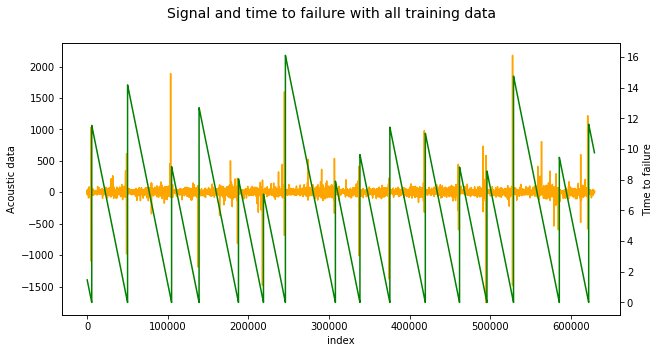

In [9]:
single_timeseries(629145000, step=1000, title="Signal and time to failure with all training data")